# <span style="color:blue">EVCO Practical 7: Competitive Coevolution with fitness sharing</span>

Simon O'Keefe: simon.okeefe@york.ac.uk

Danny Roberts: danny.roberts@york.ac.uk

Tianda Sun: tianda.sun@york.ac.uk

## <span style="color:#0073e6">Learning objectives</span>

- To implement a simple competitive coevolutionary algorithm using DEAP
- To understand how the populatios interact and the impact of changing parameters in each population
- Understand coevolutionary dynamics such as cycling and over-specialisation
- Implement a common version of fitness sharing (diversity measure)

# <span style="color:Blue">Code for the competitive coevolution example</span>

In [1]:
import random
from deap import base
from deap import creator
from deap import tools
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython import display

In [3]:
NUM_GENES = 100

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

toolbox.register("Individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, NUM_GENES)

toolbox.register("Population", tools.initRepeat, list, toolbox.Individual)

Because this is fast to run, I use a seperate evaluation for the host and for the parasite and randomize the opponents for each.

In [4]:
NUM_OPPONENTS = 5

In [5]:
def evalHost(individual):
    fit = 0.0

    # Select NUM_OPPONENTS random individuals from the parasite population
    opponentIndexes = np.random.choice(len(popParasite), size=NUM_OPPONENTS, replace=False)
    opponents = [popParasite[i] for i in opponentIndexes]

    for opp in opponents:
        x = sum(opp)
        p = 0.5 * ( 1 + np.tanh( (x - 50) / 7 ) )
        if random.random() < p:
            matchingOnes = True
        else:
            matchingOnes = False
        for i in range(len(individual)):
            if matchingOnes and opp[i] == 1 and individual[i] == 0:
                fit += 1
            elif not(matchingOnes) and opp[i] == 0 and individual[i] == 1:
                fit += 1

    return (fit/NUM_OPPONENTS),

In [6]:
def evalParasite(individual):
    fit = 0.0

    x = sum(individual)
    p = 0.5 * ( 1 + np.tanh( (x - 50) / 7 ) )
    if random.random() < p:
        matchingOnes = True
    else:
        matchingOnes = False

    # Select numOpponents random individuals from the host population
    opponentIndexes = np.random.choice(len(popHost), size=NUM_OPPONENTS, replace=False)
    opponents = [popHost[i] for i in opponentIndexes]

    for opp in opponents:
        for i in range(len(individual)):
            if individual[i] == opp[i]:
                if matchingOnes and opp[i] == 1 and individual[i] == 1:
                    fit += 1
                elif not(matchingOnes) and opp[i] == 0 and individual[i] == 0:
                    fit += 1

    return (fit/NUM_OPPONENTS),

In [7]:
toolbox.register("evaluateHost", evalHost)
toolbox.register("evaluateParasite", evalParasite)
toolbox.register("mutateHost", tools.mutFlipBit, indpb=0.1)
toolbox.register("mutateParasite", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=6)

This is where I have implemented fitness sharing

In [8]:
# For this problem, we know that the Hamming distance will be between 0 (no difference) and the number of genes (100 - entirely different)
def hamming_distance(s1, s2):
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

# Sigma is the minimum distance for sharing
# Alpha is the sharing parameter for how much to penalize similar solutions
# With sigma set to 5 we will only penalize our individual for being similar to individuals within a hamming distance of 5
def sharing(distance, sigma, alpha):
    res = 0
    if distance < sigma:
        res += 1 - (distance/sigma)**alpha
    return res

def shared_fitness(individual, population, sigma = 5, alpha = 0.5):
    num = individual.fitness.values[0]

    dists = [hamming_distance(individual, x) for x in population]  
    res = [sharing(d, sigma, alpha) for d in dists]
    den = sum(res)

    return num/den,

In [9]:
POPSIZE = 50
NGEN = 150
#random.seed(99)

popHost = toolbox.Population(n=POPSIZE)
popParasite = toolbox.Population(n=POPSIZE)

In [10]:
# Evaluate the entire host population's basic fitness
fitnessesHost = map(toolbox.evaluateHost, popHost)
for ind, fit in zip(popHost, fitnessesHost):
    ind.fitness.values = fit

# Evaluate the entire host population's shared fitness (using fitness sharing)
for ind in popHost:
    ind.fitness.values = shared_fitness(ind, popHost)

# Evaluate the entire parasite population's basic fitness   
fitnessesParasite = map(toolbox.evaluateParasite, popParasite)
for ind, fit in zip(popParasite, fitnessesParasite):
    ind.fitness.values = fit
    
for ind in popParasite:
    ind.fitness.values = shared_fitness(ind, popParasite)

-- End of coevolution --


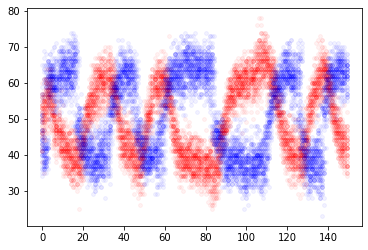

In [11]:
# Begin the evolution generations
for g in range(NGEN):
    #print("-- Generation %i --" % g)

    # ----- HOSTS --------
    offspringHost = toolbox.select(popHost, len(popHost))
    offspringHost = list(map(toolbox.clone, offspringHost))

    for mutant in offspringHost:
        toolbox.mutateHost(mutant)

    fitnessesHost = map(toolbox.evaluateHost, offspringHost)
    for ind, fit in zip(offspringHost, fitnessesHost):
        ind.fitness.values = fit
        
    # Evaluate the entire host population's shared fitness (using fitness sharing)
    for ind in popHost:
        ind.fitness.values = shared_fitness(ind, popHost)

    # ----- PARASITES --------
    offspringParasite = toolbox.select(popParasite, len(popParasite))
    offspringParasite = list(map(toolbox.clone, offspringParasite))

    for mutant in offspringParasite:
        toolbox.mutateParasite(mutant)

    fitnessesParasite = map(toolbox.evaluateParasite, offspringParasite)
    for ind, fit in zip(offspringParasite, fitnessesParasite):
        ind.fitness.values = fit

    for ind in popParasite:
        ind.fitness.values = shared_fitness(ind, popParasite)
        
    #-- Reproduce both hosts and parasites --
    popHost[:] = offspringHost
    popParasite[:] = offspringParasite

    # Gather all the fitnesses in one list and print the stats
    fitsHost = [ind.fitness.values[0] for ind in popHost]
    fitsParasite = [ind.fitness.values[0] for ind in popParasite]
    #print ("Host: " + str(np.mean(fitsHost)) )
    #print ("Parasite: " + str(np.mean(fitsParasite)) )

    # Instead of loop make this a vector
    #for index in range(POPSIZE):
    gen = [g] * POPSIZE
    host = [sum(x) for x in popHost]
    parasite = [sum(x) for x in popParasite]
    plt.scatter( gen, host, color='red', s=15, alpha=0.05)
    plt.scatter( gen, parasite, color='blue', s=15, alpha=0.05)
    display.display(plt.gcf())
    display.clear_output(wait=True)
  

print("-- End of coevolution --")